# All plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])
    
def create_latency_plots(path, window_size=20, marker_size=50, GTnumber=-1, source = ''):
    sns.set(font_scale=1.5)

    df_raw = pd.read_csv(path + '.csv')
    # Extract the data block index from the Block ID in the raw DataFrame
    df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
    # remove aalborg
    # df_raw = df_raw[(df_raw['Source'] != 'Aalborg, Denmark') & (df_raw['Destination'] != 'Aalborg, Denmark')]
    # Sort the DataFrame by paths (Source and Destination)
    df = df_raw.sort_values(by=['Source', 'Destination', 'Block Index'])
    # Calculate the rolling average for each unique path (combination of Source and Destination)
    df['Path'] = df['Source'].astype(str) + ' -> ' + df['Destination'].astype(str)
    df['Latency_Rolling_Avg'] = df.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())
    
    # Metrics for x-axis
    # metrics = ['Arrival Time', 'Block Index', 'Creation Time']
    metrics = ['Arrival Time', 'Creation Time']

    # Create subplots
    fig, axes = plt.subplots(len(metrics), 2, figsize=(18, 18))
    
    for i, metric in enumerate(metrics):
        # Line Plots on the left (column index 0)
        sns.lineplot(x=metric, y='Latency_Rolling_Avg', hue='Path', ax=axes[i, 0], data=df, legend=False)
        axes[i, 0].set_title(f'Latency Trends Over {metric} (Window Size = {window_size})')
        axes[i, 0].set_xlabel(metric)
        axes[i, 0].set_ylabel('Latency (Rolling Average)')
        
        # Scatter Plots on the right (column index 1)
        sns.scatterplot(x=metric, y='Latency', hue='Path', ax=axes[i, 1], data=df, marker='o', s=marker_size, legend=False)
        axes[i, 1].set_title(f'Individual Latency Points Over {metric}')
        axes[i, 1].set_xlabel(metric)
        axes[i, 1].set_ylabel('Latency')
        
    # Adjust the layout
    plt.tight_layout()
    # plt.savefig(outputPath + '/pngAllLatencies/' + '{}_gateways_All_Latencies_subplots.png'.format(GTnumber), dpi = 300)
    plt.savefig(path + '.png', dpi = 300)
    plt.show()
    plt.close()
    sns.set(font_scale=1.0)


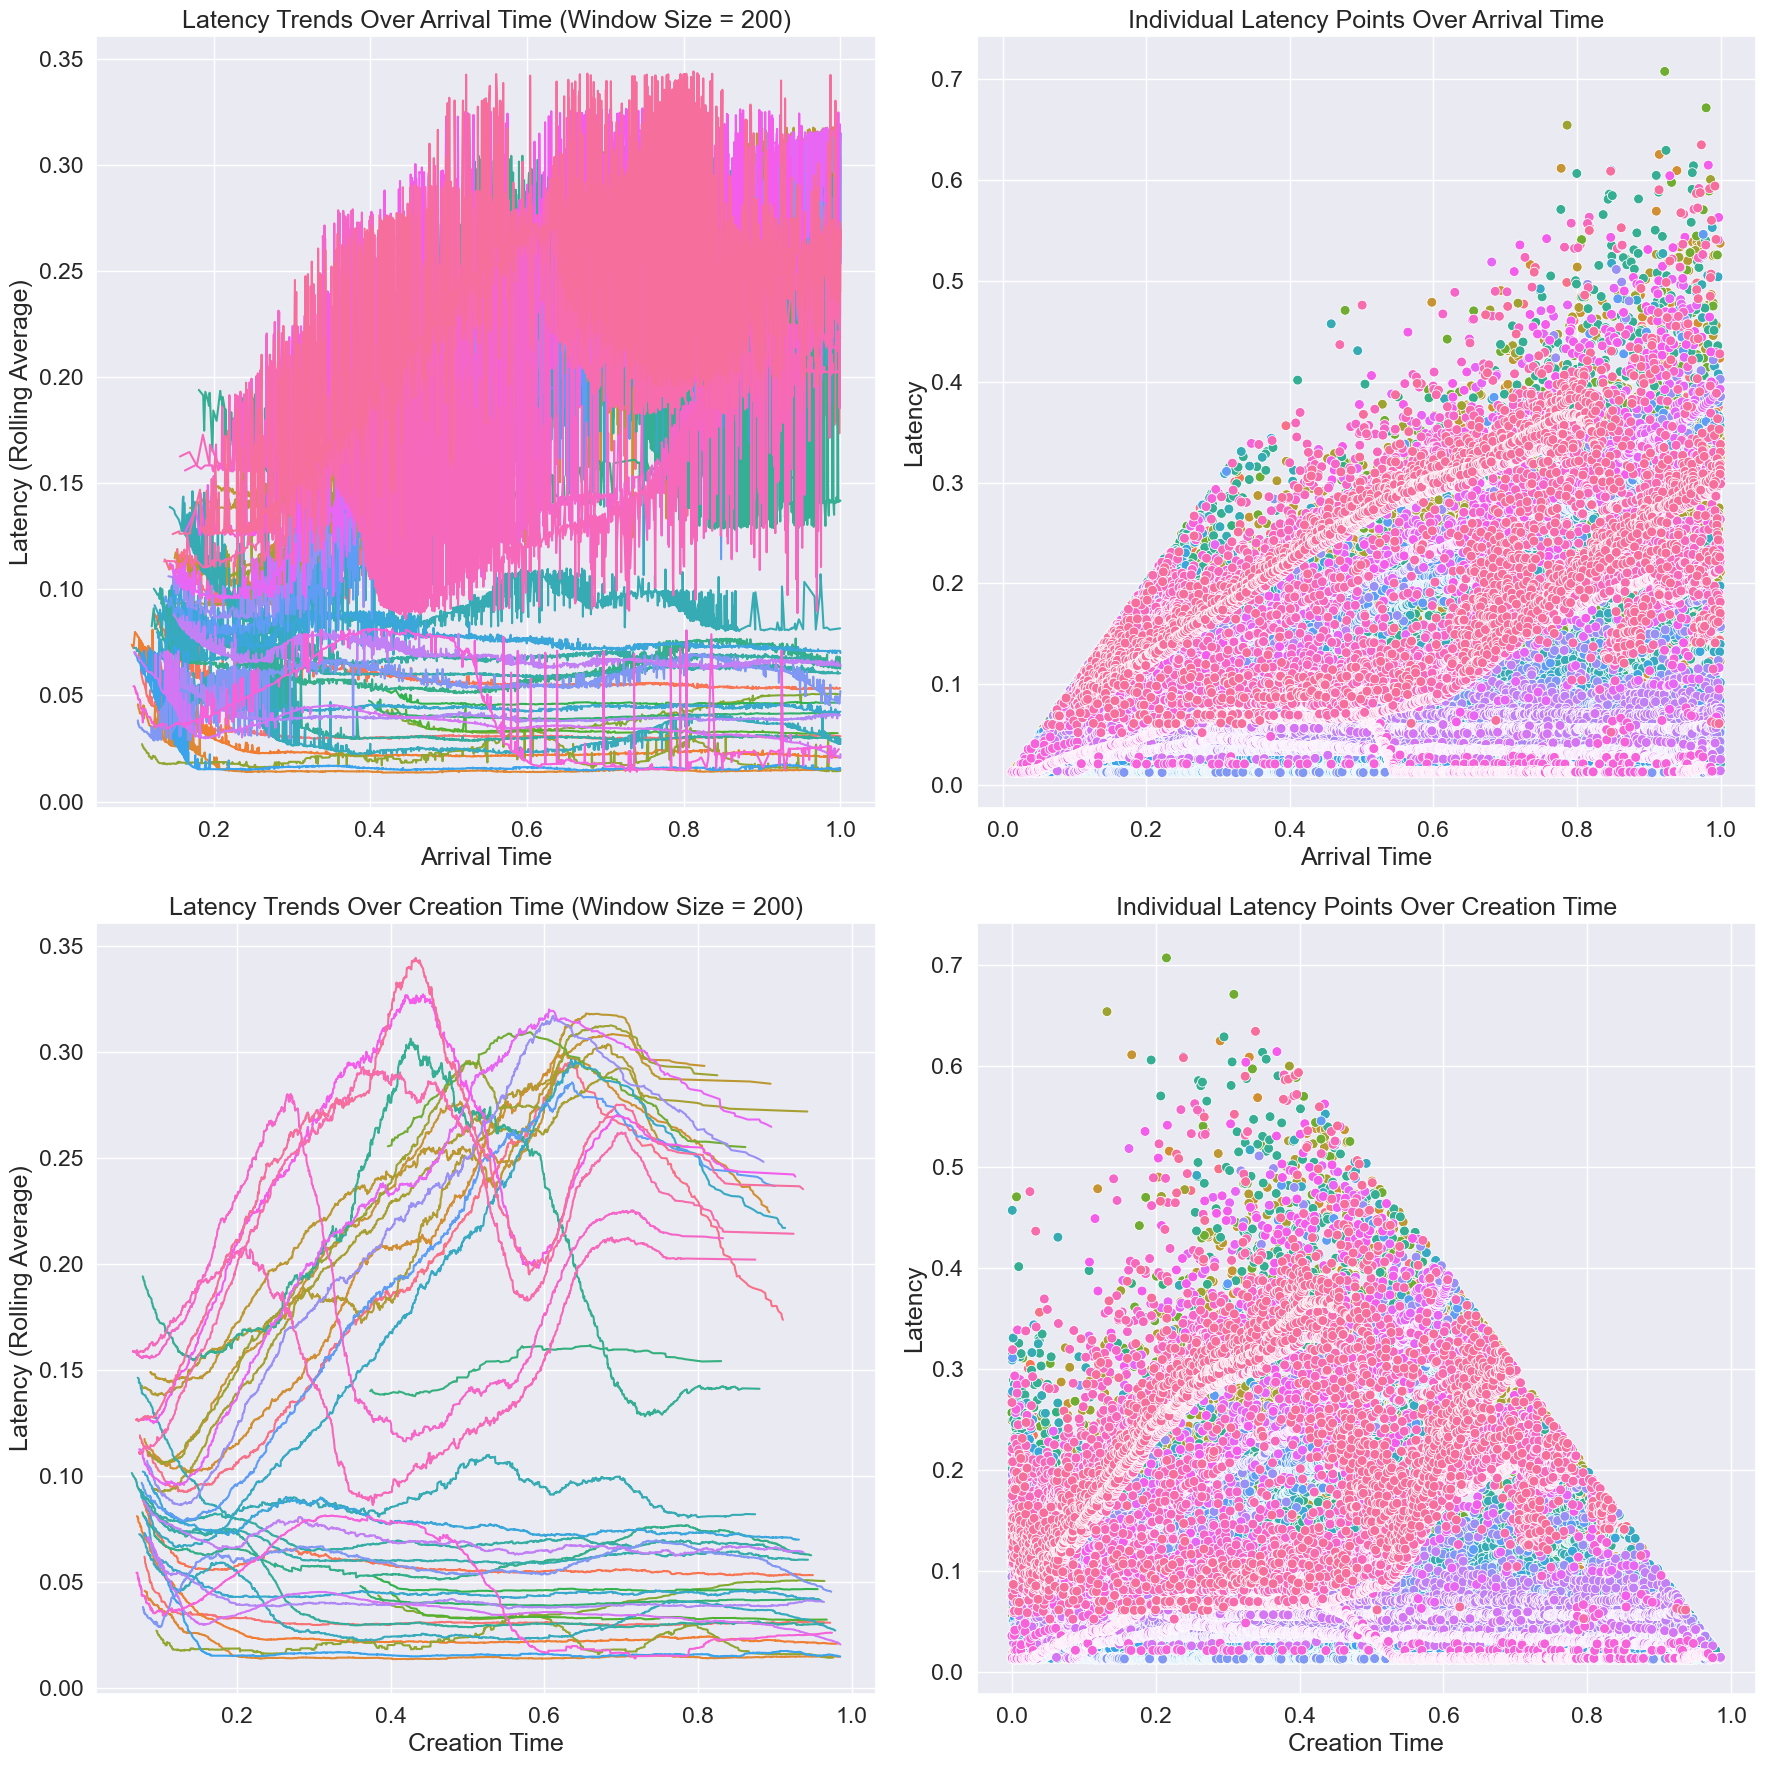

In [5]:
# Read the newly uploaded CSV file into a raw DataFrame
path = './allLatencies_7_gateways'

# Test the updated function on the raw DataFrame with a window size of 200
create_latency_plots(path, window_size=200)



# One plot per path

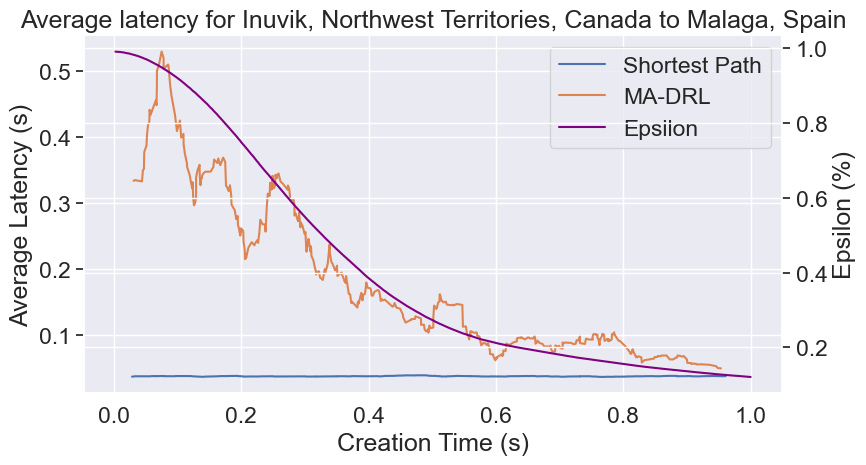

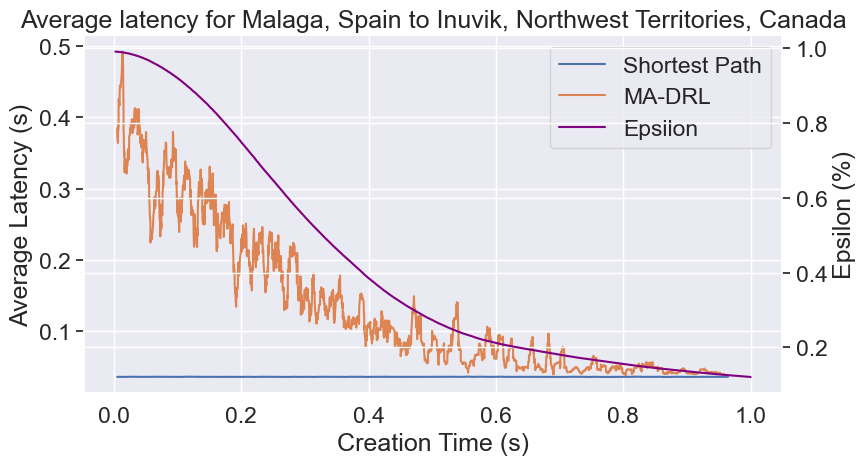

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_latency_plots_with_epsilon_combined_legend(path1, path2, epsilon_path, window_size=20, marker_size=50, GTnumber=-1, label1='Shortest Path', label2='MA-DRL'):
    sns.set(font_scale=1.5)

    # Load datasets
    df1_raw = pd.read_csv(path1 + '.csv')
    df2_raw = pd.read_csv(path2 + '.csv')
    epsilon_df = pd.read_csv(epsilon_path)

    # Process latency data
    for df_raw in [df1_raw, df2_raw]:
        df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
        df_raw.sort_values(by=['Source', 'Destination', 'Block Index'], inplace=True)
        df_raw['Path'] = df_raw['Source'].astype(str) + ' -> ' + df_raw['Destination'].astype(str)
        df_raw['Latency_Rolling_Avg'] = df_raw.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Metrics for x-axis
    metrics = ['Creation Time']

    # Create subplot for each path
    unique_paths = df1_raw['Path'].unique()
    for path in unique_paths:
        plt.figure(figsize=(9, 5))

        # Filter data for the current path
        df1_path = df1_raw[df1_raw['Path'] == path]
        df2_path = df2_raw[df2_raw['Path'] == path]

        # Create twin axis for epsilon
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # Plot latency trends for both policies
        line1 = sns.lineplot(x=metrics[0], y='Latency_Rolling_Avg', data=df1_path, label=label1, markersize=marker_size, ax=ax1)
        line2 = sns.lineplot(x=metrics[0], y='Latency_Rolling_Avg', data=df2_path, label=label2, markersize=marker_size, ax=ax1)

        # Plot epsilon trend
        # line3 = sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', ax=ax2)
        line3 = sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', label='Epsilon', ax=ax2)#, legend = 'false')

        # Combine legends
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')
        ax2.get_legend().remove()


        path = path.replace(' -> ', ' to ')  # For file naming
        plt.title(f'Average latency for {path}')
        ax1.set_xlabel(metrics[0] + ' (s)')
        ax1.set_ylabel('Average Latency (s)')
        ax2.set_ylabel('Epsilon (%)')
        plt.tight_layout()

        if GTnumber >= 0:
            plt.savefig(f'{path}.png', dpi=300)
        else:
            plt.savefig(f'{path}.png', dpi=300)

        plt.show()
        plt.close()

    sns.set(font_scale=1.0)

# Example usage:
compare_latency_plots_with_epsilon_combined_legend('allLatencies_2_gatewaysDR', 'allLatencies_2_gateways', 'epsilons_2_gateways.csv', window_size=20, marker_size=5, GTnumber=4)


# Correlation of paths

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def create_correlation_plot(df, metric='Creation Time'):
    sns.set(font_scale=1.5)
    df['Path'] = df['Source'].astype(str) + ' -> ' + df['Destination'].astype(str)
    
    # Calculate the correlation of 'Latency' with the chosen metric for each path
    path_correlations = df.groupby('Path').apply(lambda x: x['Latency'].corr(x[metric]))
    
    # Create a new DataFrame for plotting
    correlation_df = path_correlations.reset_index(name='Correlation')
    
    # Create a bar plot to visualize the correlation for each path
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Correlation', y='Path', data=correlation_df.sort_values('Correlation', ascending=False))
    plt.title(f'Correlation of Latency with {metric} Over Time for Each Route')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Path')
    plt.tight_layout()
    plt.show()
    sns.set(font_scale=1.0)

# Read the CSV file into a DataFrame
source = './allLatencies_8_gatewaysSR'
df_raw = pd.read_csv(source + '.csv')

# Optionally remove a location, if required
# df_raw = df_raw[(df_raw['Source'] != 'Aalborg, Denmark') & (df_raw['Destination'] != 'Aalborg, Denmark')]

# Extract the block index from the Block ID
df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)

# Sort the DataFrame by paths (Source and Destination)
df_sorted = df_raw.sort_values(by=['Source', 'Destination', 'Block Index'])

# Call the function to create the latency plots
# create_latency_plots(df_sorted, window_size=200)

# Call the function to create the correlation plot
create_correlation_plot(df_sorted, metric='Block Index')

# Display the raw DataFrame
df_raw
